## Bibliotecas

In [1]:
import random
import math

import pandas as pd
import matplotlib.pyplot as plt

from functools import partial
from scipy.stats import t, chi2

## Códigos auxiliares

In [2]:
from utils import *

## Variáveis globais

In [3]:
# N_RODADAS = 3200
N_RODADAS = 32 

# N_AMOSTRAS = 10000
N_AMOSTRAS = 100000

RHOS = [0.2, 0.4, 0.6, 0.8, 0.9]

CHEGADA = 0
FIM_DO_SERVICO_1 = 1
FIM_DO_SERVICO_2 = 2

MU = 1.0

LIVRE = 0
OCUPADO = 1

FCFS = 1
LCFS = 0

## Funcionamento geral

### Gerando VAs exponenciais
Resultado mostrado na aula 5, slide 5.

In [4]:
def gera_exponencial(rho):

    # Gera VA uniforme no intervalo [0.0, 1.0)
    u0 = random.random()

    # Pega amostra da exponencial
    x0 = -math.log(u0)/ rho

    return x0

### Gerando números aleatórios
Os seeds em Python são definidos por meio da função random.seed(int) e fixamos um seed antes cada simulação para garantir a reprodutibilidade dos resultados. Para garantir a independência dos seeds, rodamos o algoritmo com alguns seeds diferentes ao longo do trabalho.

Além disso também fizemos alguns testes para mostrar que não há sobreposição entre os intervalos gerados pelos seeds.

Mesmo usando seeds próximas (0 e 1, por exemplo) não encontramos sobreposição das sequências de valores nem uma correlação significativa. Acreditamos que isso se deve ao fato de o Python utilizar o algoritmo do Mersenne Twister para gerar números pseudoaleatórios (https://en.wikipedia.org/wiki/Mersenne_Twister).

In [5]:
def gera_amostras(rho, seed):

    rodadas = []

    random.seed(seed)
    
    for _ in range(N_RODADAS):
        amostras = []

        for _ in range(N_AMOSTRAS):
            amostras.append(gera_exponencial(rho))
        
        rodadas.append(amostras)
    
    # Lista de rodadas com números aleatórios gerados pela amostra exponencial
    return rodadas

#### Teste 1

Primeiro geramos 2 vetores com váriaveis exponenciais com mesma taxa, cada um a partir de uma seed diferente. E depois verificamos se existem valores em comuns nesses vetores.

In [6]:
def teste_gera_amostras(rodadas_A, rodadas_B):

    tamanho_lista_rodadas = len(rodadas_A)

    for rodada_A in range(tamanho_lista_rodadas - 1):
        lista_rodada = rodadas_A[rodada_A]

        for rodada_B in range(tamanho_lista_rodadas):
            verifica_lista = rodadas_B[rodada_B]

            verificacao = list(set(lista_rodada).intersection(verifica_lista))
            if(len(verificacao) > 0):
                return "Foram encontrados valores iguais"
            
    return "Não há valores iguais entre as duas rodadas"       

Exemplo:

In [7]:
rodadas_A = gera_amostras(0.3, 0)
rodadas_B = gera_amostras(0.3, 1)

teste_gera_amostras(rodadas_A, rodadas_B)

'Não há valores iguais entre as duas rodadas'

#### Teste 2

No outro teste geramos 2 vetores também e verificamos o indíce de correlação (Pearson) entre eles.

- +1: correlação positiva completa
- +0.8: correlação positiva forte
- +0.6: correlação positiva moderada
- 0: nenhuma correlação
- -0.6: correlação negativa moderada
- -0.8: correlação negativa forte
- -1: correlação negativa completa

Referência: https://stackabuse.com/calculating-pearson-correlation-coefficient-in-python-with-numpy/


In [8]:
def teste_pearson_gera_amostras(seed_1, seed_2):

    rodadas = []
    amostras_1 = []
    amostras_2 = []

    random.seed(seed_1)
    for _ in range(N_AMOSTRAS):
        amostras_1.append(random.random())
    rodadas.append(amostras_1)

    random.seed(seed_2)
    for _ in range(N_AMOSTRAS):
        amostras_2.append(random.random())
    rodadas.append(amostras_2)

    x_pearson = pd.Series(rodadas[0])
    y_pearson = pd.Series(rodadas[1])

    resultado = x_pearson.corr(y_pearson)

    return resultado

Exemplo:

In [9]:
teste_pearson_gera_amostras(0, 1)

0.0021411007061130304

### Eventos

In [10]:
class Evento:

    def __init__(self, tipo_evento, instante_t, tempo_execucao, id_cliente):
        self.tipo_evento = tipo_evento
        self.instante_t = instante_t #tempo em que o evento foi criado + tempo até ser executado
        self.tempo_execucao = tempo_execucao #tempo até ser executado
        self.id_cliente = id_cliente

    # Define como a classe é impressa
    def __repr__(self):
        if(self.tipo_evento == CHEGADA):
            escreve_string = "CHEGADA"
        elif self.tipo_evento == FIM_DO_SERVICO_1:
            escreve_string = "FIM DO SERVIÇO 1"
        else:
            escreve_string = "FIM DO SERVIÇO 2"

        return f"Tipo de evento: {escreve_string}\n Instante: {self.instante_t}\n ID Cliente: {self.id_cliente}"

Exemplo:

In [11]:
evento = Evento(CHEGADA, 0.1, 0, 0)
evento

Tipo de evento: CHEGADA
 Instante: 0.1
 ID Cliente: 0

### Clientes

In [12]:
class Cliente:

    def __init__(self, chegada_evento, cor):
        self.id = chegada_evento.id_cliente
        self.tempo_chegada = chegada_evento.instante_t
        self.tempo_execucao_1 = 0.0
        self.tempo_execucao_2 = 0.0
        self.tempo_espera_1 = 0.0
        self.tempo_espera_2 = 0.0
        self.cor = cor

    # Define como a classe é impressa
    def __repr__(self):
        return f"""ID: {self.id}
        Tempo de chegada: {self.tempo_chegada}
        Tempo de espera na fila 1: {self.tempo_espera_1}
        Tempo de execucao no servico 1: {self.tempo_execucao_1}
        Tempo de espera na fila 2: {self.tempo_espera_2}
        Tempo de execucao no servico 2: {self.tempo_execucao_2}"""

In [13]:
def cria_cliente(evento, cor):
    novo_cliente = Cliente(evento, cor)
    return novo_cliente

Exemplo:

In [14]:
cor = "%06x" % random.randint(0, 0xFFFFFF)
cliente = cria_cliente(evento, cor)
cliente

ID: 0
        Tempo de chegada: 0.1
        Tempo de espera na fila 1: 0.0
        Tempo de execucao no servico 1: 0.0
        Tempo de espera na fila 2: 0.0
        Tempo de execucao no servico 2: 0.0

### Gerando chegadas

In [15]:
def gera_chegadas(instante_t, distribuicao_chegada, id_cliente):
    chegada = distribuicao_chegada()
    chegada = Evento(CHEGADA, instante_t + chegada, chegada, id_cliente)
    return chegada

Exemplo:

In [16]:
chegada = gera_chegadas(1, partial(gera_exponencial, 0.3), 0)
chegada

Tipo de evento: CHEGADA
 Instante: 2.886248837747606
 ID Cliente: 0

### Gerando fins de serviço

In [17]:
def gera_fim_servico(instante_t, distribuicao_servico, id_cliente, tipo):
    servico = distribuicao_servico()
    fim_servico = Evento(tipo, instante_t + servico, servico, id_cliente)
    return fim_servico

Exemplo:

In [18]:
fim_servico = gera_fim_servico(10, partial(gera_exponencial, 0.3), 1, FIM_DO_SERVICO_1)
fim_servico

Tipo de evento: FIM DO SERVIÇO 1
 Instante: 12.428633374477153
 ID Cliente: 1

### Lista de eventos

### Fila de clientes

### Serviço

### Intervalos de confiança

#### T-Student
Resultado apresentado na aula 7, slides 4 e 6.

In [19]:
t_student_percentil = t(df = N_AMOSTRAS - 1).ppf((0.025, 0.975))[1]

def t_student(media, variancia):

    # Verifica se a média e variância têm valores nulos (ou próximos disso)
    if(math.isclose(media, 0, abs_tol = 1e-9)):
        media = 0

    if(math.isclose(variancia, 0, abs_tol = 1e-9)):
        variancia = 0

    # Se a média e variância forem nulas
    if(not(media or variancia)):
        return 0.0, 0.0, 0.0

    desvio_padrao = math.sqrt(variancia)

    # Metade do intervalo
    metade = t_student_percentil * (desvio_padrao/ math.sqrt(N_AMOSTRAS))

    # Limite superior do intervalo
    limite_superior = media + metade

    # Limite inferior do intervalo
    limite_inferior = media - metade

    # Precisão do intervalo
    precisao = metade/ media

    return limite_superior, limite_inferior, precisao

#### Chi-Quadrado
Resultado apresentado na aula 7, slides 12 ao 14.

In [20]:
chi2_0025_percentil, chi2_0975_percentil = chi2(df = N_AMOSTRAS - 1).ppf((0.025, 0.975))

def chi_quadrado(variancia):

    if(variancia == 0.0):
        return 0.0, 0.0, 0.0

    else:
        limite_superior = (N_AMOSTRAS) * variancia/ chi2_0975_percentil
        limite_inferior = (N_AMOSTRAS) * variancia/ chi2_0025_percentil

        # Enunciado pede que seja aproximadamente 0.05
        precisao = (chi2_0975_percentil - chi2_0025_percentil)/ (chi2_0975_percentil + chi2_0025_percentil)

        return limite_superior, limite_inferior, precisao

### Estimadores

Essa classe permitey o cálculo iterativo da média e da variãncia de uma variável, recebendo uma amostra de cada vez.
Esse resultado foi apresentado na aula 7, slide 19.

In [27]:
class Estimador:

    def __init__(self, debug=False):
        self.soma_amostras = 0.0
        self.quadrado_soma_amostras = 0.0
        self.numero_amostras = 0
        self.debug = debug
        
        self.medias = []
        self.variancias = []
        self.pesos = []

    def adiciona_amostra(self, amostra, peso=1):
        peso = 1
        self.soma_amostras += amostra*peso
        self.quadrado_soma_amostras += ((amostra) ** 2)
        self.numero_amostras += peso
        
        #salvar resultados intermediários para plots futuros
        if self.debug and self.numero_amostras > 1:
            self.pesos.append(self.numero_amostras)
            self.medias.append(self.media())
            self.variancias.append(self.variancia())

    def media(self):
        return self.soma_amostras/ self.numero_amostras

    def variancia(self):
        termo_auxiliar_1 = self.quadrado_soma_amostras/ (self.numero_amostras - 1)
        termo_auxiliar_2 = (self.soma_amostras ** 2)/ (self.numero_amostras * (self.numero_amostras - 1))
        return termo_auxiliar_1 - termo_auxiliar_2

    def t_student(self):
        return t_student(self.media(), self.variancia())

    def variancia_chi_quadrado(self):
        return chi_quadrado(self.variancia())

    def chi_quadrado(self):
        return chi_quadrado(self.media())

In [28]:
estimador = Estimador(debug=True)
estimador.adiciona_amostra(10)
estimador.adiciona_amostra(15)
estimador.adiciona_amostra(10)
estimador.adiciona_amostra(15)
estimador.adiciona_amostra(10)
estimador.adiciona_amostra(10)
estimador.t_student()[2]

0.0013717056531909267

## Simulador

### Base

Código base para simular o sistema com prints depurativos para acompanhar chegadas

In [29]:
random.seed(13) #setando uma seed pra manter os testes iguais

mu = MU
lamb = RHOS[2]/2

fila1 = []
fila2 = []
tempo = 0
eventos = [ gera_chegadas(0, partial(gera_exponencial, lamb), 0) ] # começa populando com uma chegada

i = 1
while i < 10: #loop de eventos, chegada de 10 clientes
    atual = eventos.pop(0)
    tempo = atual.instante_t
    print("Tempo", tempo)
    
    if atual.tipo_evento == CHEGADA: #evento de chegada
        fila1.append( cria_cliente(atual, cor) ) #adiciona o cliente chegado na fila
        eventos.append(gera_chegadas(tempo, partial(gera_exponencial, lamb), i) ) #cria o próximo evento de chegada
        print("Chegada", fila1[-1])
        
        checa_termino = any([e.tipo_evento == FIM_DO_SERVICO_1 for e in eventos])
        if not checa_termino: #essa foi a primeira chegada (não tem pessoas na fila 1)
            prox_fim_1 = gera_fim_servico(tempo, partial(gera_exponencial, mu), atual.id_cliente, FIM_DO_SERVICO_1) 
            eventos.append( prox_fim_1 ) #adiciona o próximo evento de término 1
            
            if len(fila2) != 0: # fila 2 tem alguém sendo executado
                prox_fim_2 = [e for e in eventos if e.tipo_evento == FIM_DO_SERVICO_2][0] #próximo término da fila 2
                prox_fim_2.instante_t += prox_fim_1.tempo_execucao #adia o fim do próximo da fila 2 para após o fim do atual da fila 1
        i+= 1
    
    elif atual.tipo_evento == FIM_DO_SERVICO_1:
        cliente = fila1.pop(0) #remove o primeiro da fila 1
        fila2.append( cliente ) #coloca cliente na fila 2
        
        #atualiza tempos do cliente
        cliente.tempo_execucao_1= atual.tempo_execucao
        cliente.tempo_espera_1 = tempo - cliente.tempo_chegada - atual.tempo_execucao
        
        checa_termino = any([e.tipo_evento == FIM_DO_SERVICO_2 for e in eventos])
        if not checa_termino: #essa foi o primeiro termino (não tem pessoas na fila 2)
            eventos.append( gera_fim_servico(tempo, partial(gera_exponencial, mu), cliente.id, FIM_DO_SERVICO_2) ) #adiciona o próximo evento de término 1
        
        if len(fila1) == 0: #se a fila 1 estiver vazia
            pass
        else: #se a fila 1 não estiver vazia
            prox_fim_1 = gera_fim_servico(tempo, partial(gera_exponencial, mu), fila1[0].id, FIM_DO_SERVICO_1)  #cria evento de término para o próximo da fila 1
            eventos.append( prox_fim_1 ) 
            
            prox_fim_2 = [e for e in eventos if e.tipo_evento == FIM_DO_SERVICO_2][0] #próximo término da fila 2
            prox_fim_2.instante_t += prox_fim_1.tempo_execucao #adia o fim do próximo da fila 2 para após o fim do atual da fila 1
        
        print("Saída 1", cliente)
        
    elif atual.tipo_evento == FIM_DO_SERVICO_2:
        cliente = fila2.pop(0)
        
        #atualiza tempos do cliente
        cliente.tempo_execucao_2= atual.tempo_execucao
        cliente.tempo_espera_2 = tempo - cliente.tempo_chegada - cliente.tempo_execucao_1 - cliente.tempo_espera_1 - atual.tempo_execucao
        
        if len(fila2) != 0:
            prox_fim_2 = gera_fim_servico(tempo, partial(gera_exponencial, mu), fila2[0].id, FIM_DO_SERVICO_2)
            eventos.append( prox_fim_2 )
            
        print("Saída 2", cliente)

    eventos.sort(key = lambda e: e.instante_t)
    print(eventos)
    print()
#eventos

Tempo 4.502981437579455
Chegada ID: 0
        Tempo de chegada: 4.502981437579455
        Tempo de espera na fila 1: 0.0
        Tempo de execucao no servico 1: 0.0
        Tempo de espera na fila 2: 0.0
        Tempo de execucao no servico 2: 0.0
[Tipo de evento: FIM DO SERVIÇO 1
 Instante: 4.88265904292863
 ID Cliente: 0, Tipo de evento: CHEGADA
 Instante: 5.762847702789278
 ID Cliente: 1]

Tempo 4.88265904292863
Saída 1 ID: 0
        Tempo de chegada: 4.502981437579455
        Tempo de espera na fila 1: -1.6653345369377348e-16
        Tempo de execucao no servico 1: 0.37967760534917544
        Tempo de espera na fila 2: 0.0
        Tempo de execucao no servico 2: 0.0
[Tipo de evento: FIM DO SERVIÇO 2
 Instante: 5.0459592641554
 ID Cliente: 0, Tipo de evento: CHEGADA
 Instante: 5.762847702789278
 ID Cliente: 1]

Tempo 5.0459592641554
Saída 2 ID: 0
        Tempo de chegada: 4.502981437579455
        Tempo de espera na fila 1: -1.6653345369377348e-16
        Tempo de execucao no servic

### Estimando a fase transiente

Para isso, colocamos a lógica do simulador em uma função e modificamos para salvar as métricas ao longo do tempo e fizemos alguns plots para visualizar onde elas se estabilizam.

In [30]:
#lamb = lambda
#mu = mu
#k = número de eventos de partidas tratados
def simulador(lamb, mu, k, debug=False):
    fila1 = []
    fila2 = []

    tempo = 0
    tempo_anterior = 0

    eventos = [ gera_chegadas(0, partial(gera_exponencial, lamb), 0) ] # começa populando com uma chegada
    estimadores = {
        "W1": Estimador(debug = debug),
        "W2": Estimador(debug = debug),

        "X1": Estimador(debug = debug),
        "X2": Estimador(debug = debug),

        "N1": Estimador(debug = debug),
        "N2": Estimador(debug = debug),

        "Nq1": Estimador(debug = debug),
        "Nq2": Estimador(debug = debug)
    }

    i = 0
    n_eventos = 0
    while n_eventos < k: #loop de eventos, tratar k clientes
        atual = eventos.pop(0)
        tempo_anterior = tempo
        tempo = atual.instante_t
        #print("Tempo", tempo, "\nEvento", atual, "\n")

        N1 = len(fila1)
        Nq1 = 0 if N1 == 0 else N1 - 1

        N2 = len(fila2)
        Nq2 = N2 if N1 > 0 or N2 == 0 else N2-1

        estimadores["N1"].adiciona_amostra(N1, peso=tempo-tempo_anterior)
        estimadores["Nq1"].adiciona_amostra(Nq1, peso=tempo-tempo_anterior)

        estimadores["N2"].adiciona_amostra(N2, peso=tempo-tempo_anterior)
        estimadores["Nq2"].adiciona_amostra(Nq2, peso=tempo-tempo_anterior)

        if atual.tipo_evento == CHEGADA: #evento de chegada
            fila1.append( cria_cliente(atual, cor) ) #adiciona o cliente chegado na fila
            eventos.append(gera_chegadas(tempo, partial(gera_exponencial, lamb), i) ) #cria o próximo evento de chegada
            #print("Chegada", fila1[-1])

            checa_termino = any([e.tipo_evento == FIM_DO_SERVICO_1 for e in eventos])
            if not checa_termino: #essa foi a primeira chegada (não tem pessoas na fila 1)
                prox_fim_1 = gera_fim_servico(tempo, partial(gera_exponencial, mu), atual.id_cliente, FIM_DO_SERVICO_1) 
                eventos.append( prox_fim_1 ) #adiciona o próximo evento de término 1

                if len(fila2) != 0: # fila 2 tem alguém sendo executado
                    prox_fim_2 = [e for e in eventos if e.tipo_evento == FIM_DO_SERVICO_2][0] #próximo término da fila 2
                    prox_fim_2.instante_t += prox_fim_1.tempo_execucao #adia o fim do próximo da fila 2 para após o fim do atual da fila 1
            i+= 1

        elif atual.tipo_evento == FIM_DO_SERVICO_1:
            cliente = fila1.pop(0) #remove o primeiro da fila 1
            fila2.append( cliente ) #coloca cliente na fila 2

            #atualiza tempos do cliente
            cliente.tempo_execucao_1= atual.tempo_execucao
            cliente.tempo_espera_1 = tempo - cliente.tempo_chegada - atual.tempo_execucao

            checa_termino = any([e.tipo_evento == FIM_DO_SERVICO_2 for e in eventos])
            if not checa_termino: #essa foi o primeiro termino (não tem pessoas na fila 2)
                eventos.append( gera_fim_servico(tempo, partial(gera_exponencial, mu), cliente.id, FIM_DO_SERVICO_2) ) #adiciona o próximo evento de término 1

            if len(fila1) == 0: #se a fila 1 estiver vazia
                pass
            else: #se a fila 1 não estiver vazia
                prox_fim_1 = gera_fim_servico(tempo, partial(gera_exponencial, mu), fila1[0].id, FIM_DO_SERVICO_1)  #cria evento de término para o próximo da fila 1
                eventos.append( prox_fim_1 ) 

                prox_fim_2 = [e for e in eventos if e.tipo_evento == FIM_DO_SERVICO_2][0] #próximo término da fila 2
                prox_fim_2.instante_t += prox_fim_1.tempo_execucao #adia o fim do próximo da fila 2 para após o fim do atual da fila 1

            #print("Saída 1", cliente)

        elif atual.tipo_evento == FIM_DO_SERVICO_2:
            cliente = fila2.pop(0)

            #atualiza tempos do cliente
            cliente.tempo_execucao_2= atual.tempo_execucao
            cliente.tempo_espera_2 = tempo - cliente.tempo_chegada - cliente.tempo_execucao_1 - cliente.tempo_espera_1 - atual.tempo_execucao

            if len(fila2) != 0:
                prox_fim_2 = gera_fim_servico(tempo, partial(gera_exponencial, mu), fila2[0].id, FIM_DO_SERVICO_2)
                eventos.append( prox_fim_2 )

            estimadores["W1"].adiciona_amostra(cliente.tempo_espera_1)
            estimadores["X1"].adiciona_amostra(cliente.tempo_execucao_1)

            estimadores["W2"].adiciona_amostra(cliente.tempo_espera_2)
            estimadores["X2"].adiciona_amostra(cliente.tempo_execucao_2)
            #print("Saída 2", cliente)
            
            n_eventos += 1 #aumenta contador de eventos de saída

        eventos.sort(key = lambda e: e.instante_t)
    return estimadores, n_eventos
    #print(eventos)
    #print()
#estimadores["Nq2"].t_student()

In [31]:
# Função auxiliar para plotar os gráficos com diferentes seeds
def auxiliar_transiente(seed, n_saidas):
    random.seed(seed) #setando uma seed pra manter os testes iguais
    lista = []
    for r in RHOS:
        mu = MU
        lamb = r/2
        estimadores, n_eventos = simulador(lamb, mu, k=n_saidas, debug=True)
        lista.append(estimadores)

    #Plot dos resultados dos estimadores
    for i, cat in enumerate(["W1", "W2", "X1", "X2", "N1", "N2", "Nq1", "Nq2"]):
        plt.figure(figsize=(12, 6))

        plt.subplot(121)
        for estimadores in lista:
            medias = estimadores[cat].medias
            plt.plot(medias)
            plt.xlabel( "Eventos tratados" if i > 3 else f"Clientes atendidos")
        plt.legend(RHOS)
        plt.title(f"E[{cat}]")

        plt.subplot(122)
        for estimadores in lista:
            variancias = estimadores[cat].variancias
            plt.plot(variancias)
            plt.xlabel( "Eventos tratados" if i > 3 else f"Clientes atendidos")
        plt.legend(RHOS)
        plt.title(f"V[{cat}]")

        #plt.suptitle(cat)
        plt.show()

Usando seed 13

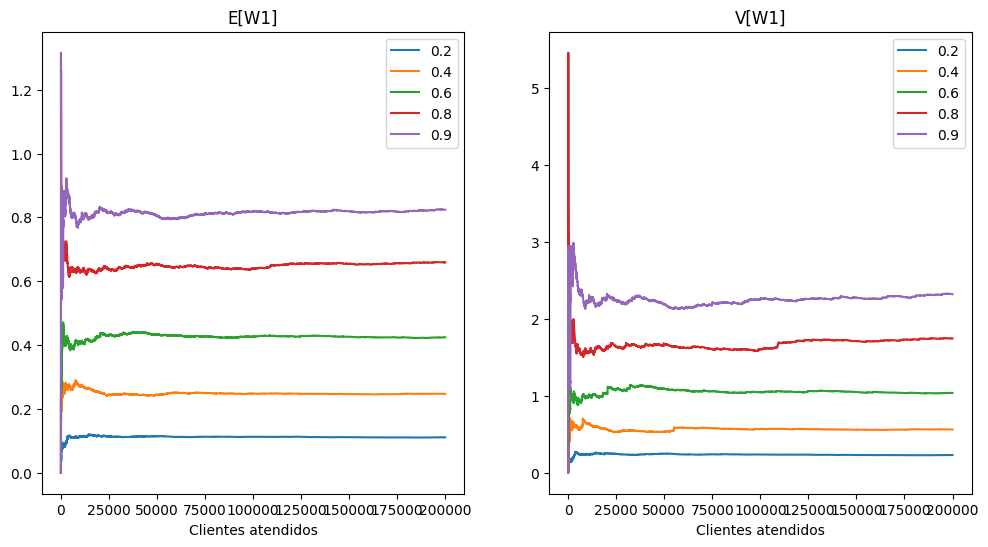

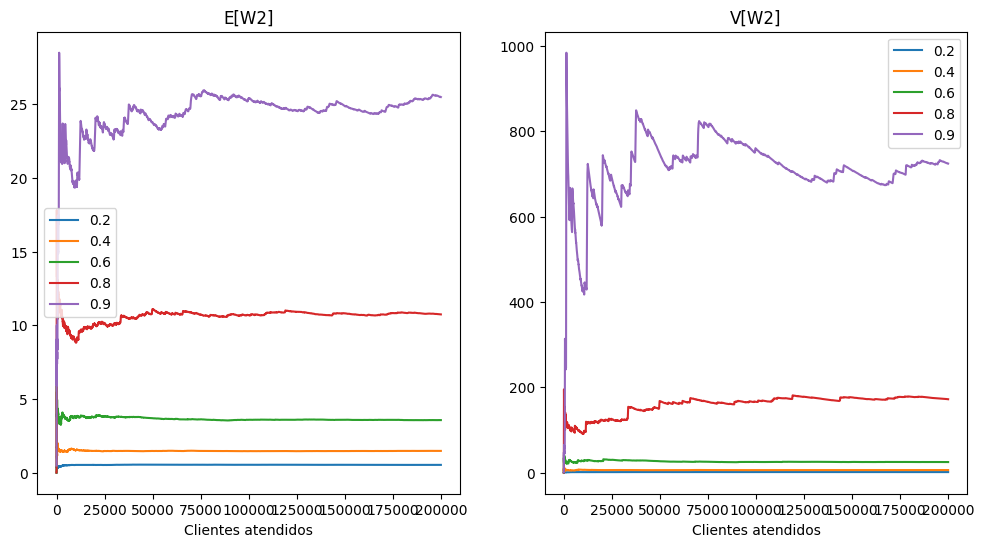

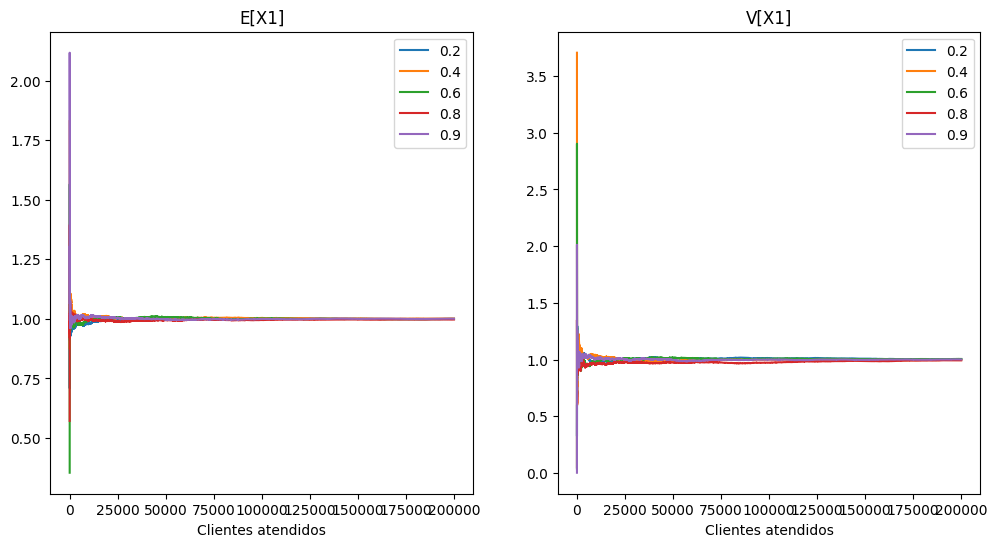

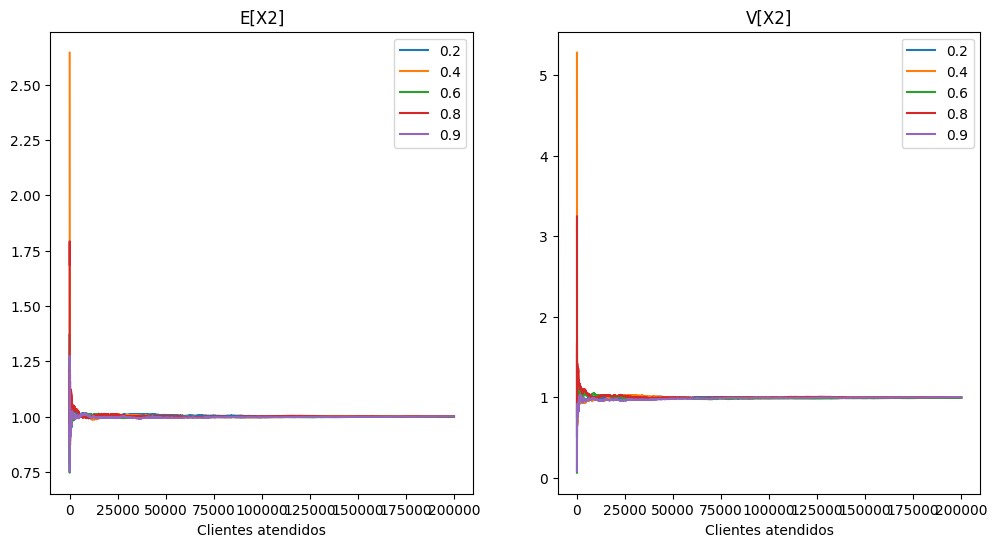

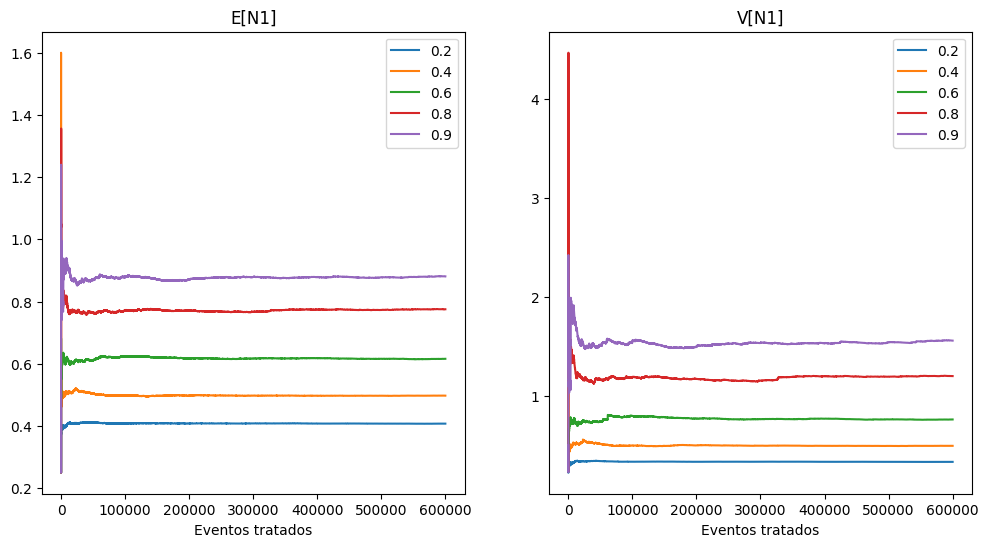

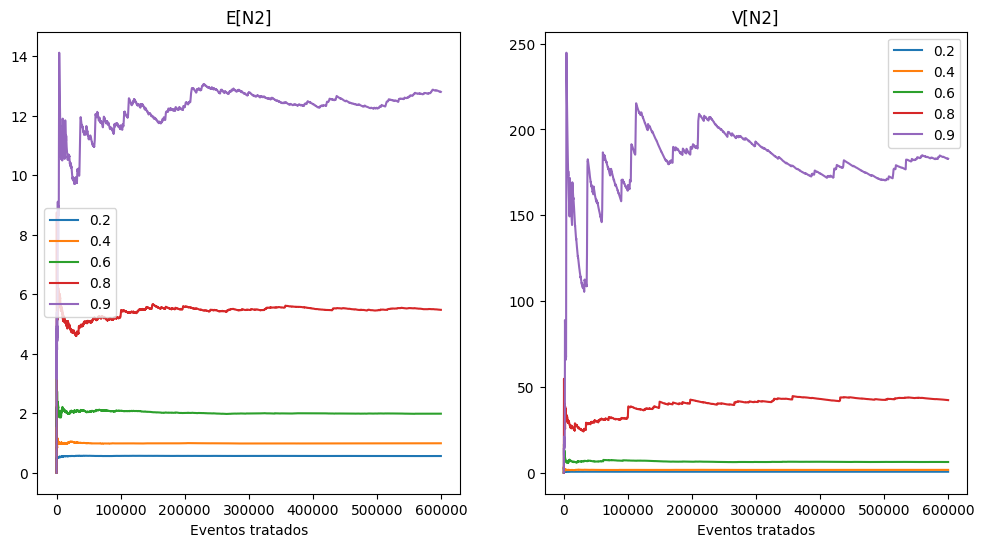

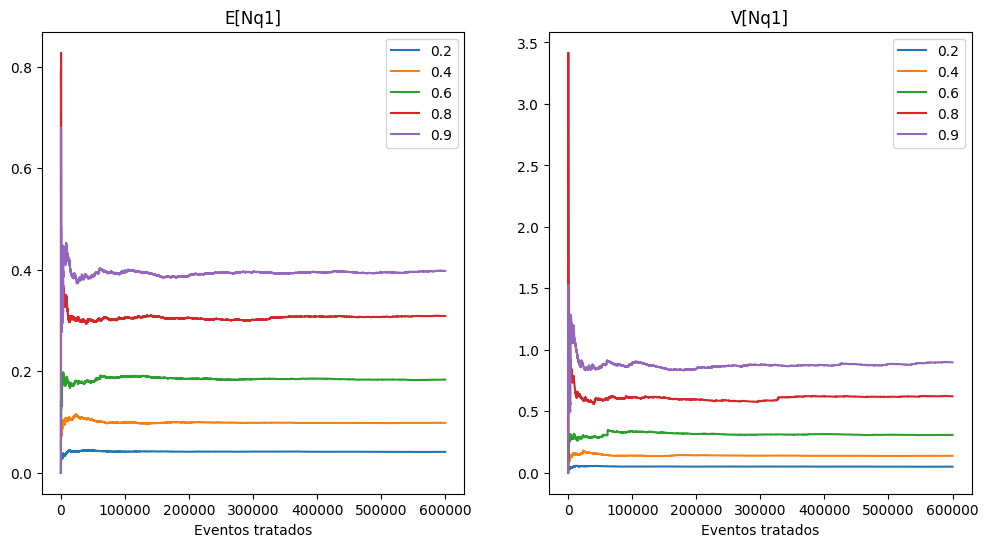

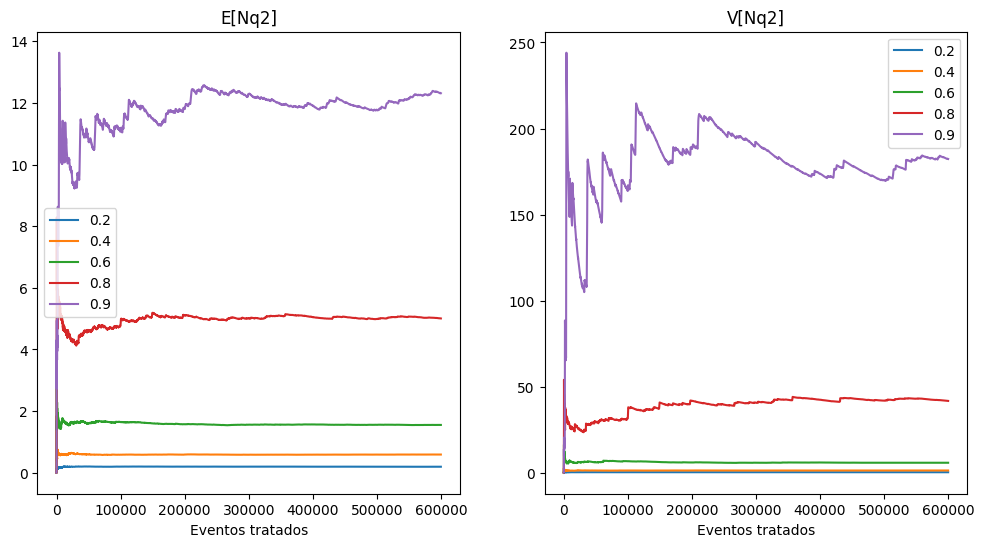

In [32]:
auxiliar_transiente(13, 200_000)

Usando seed 42

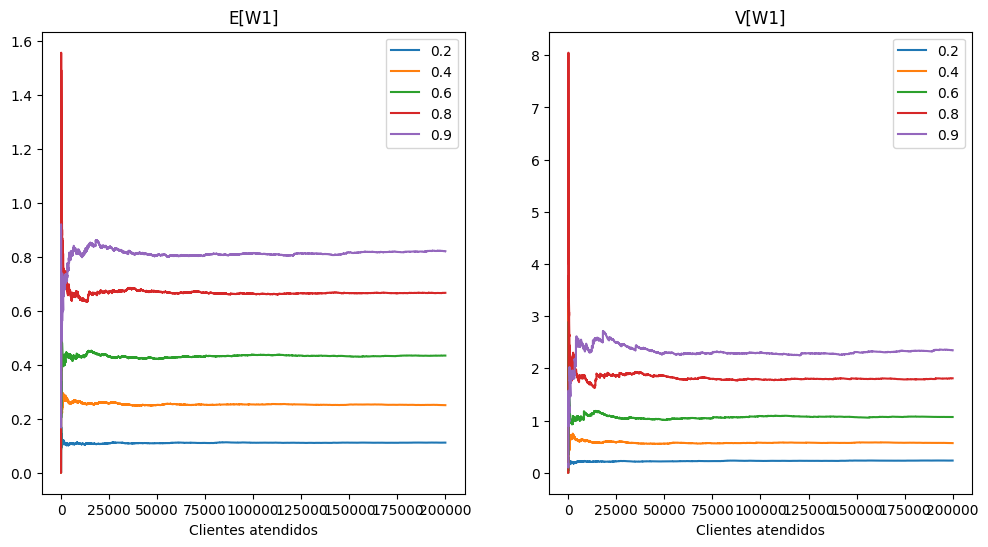

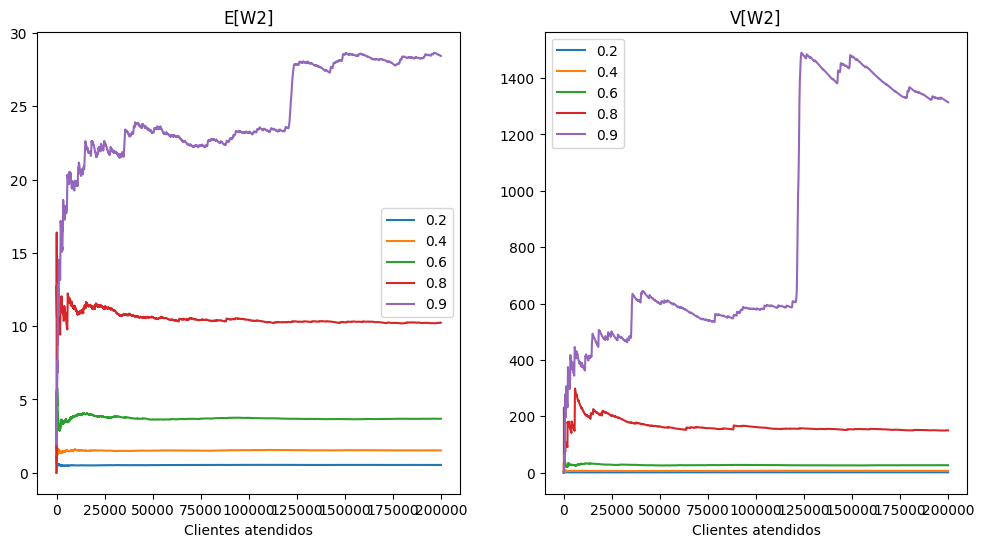

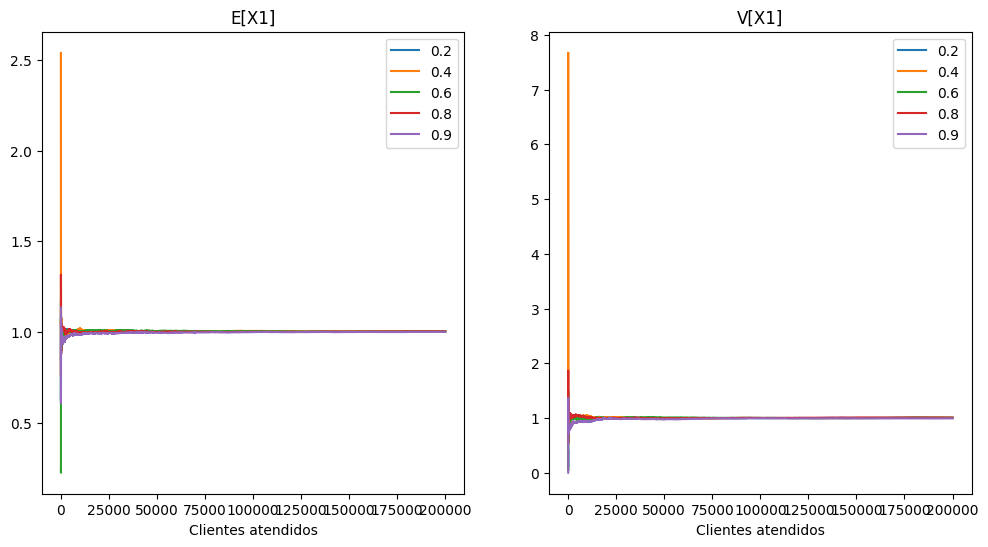

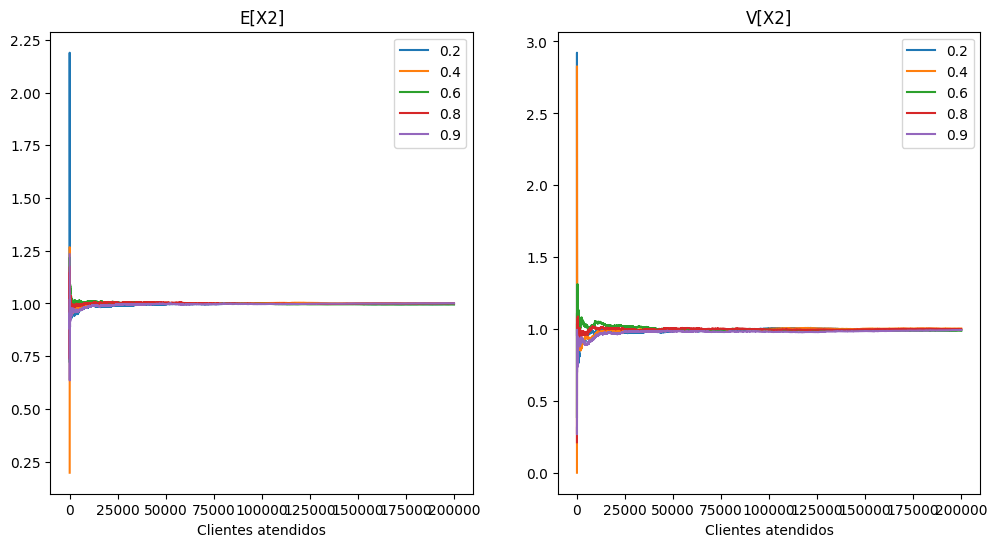

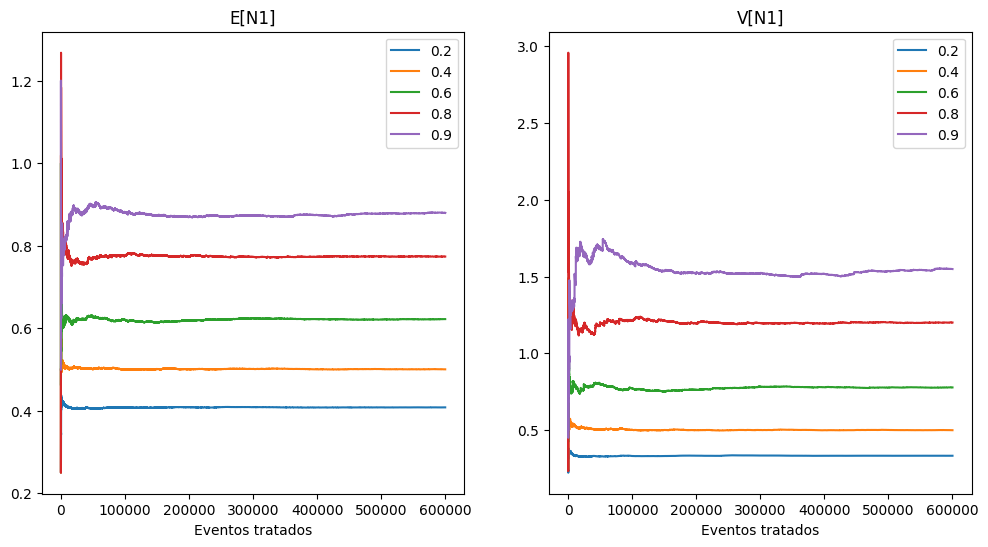

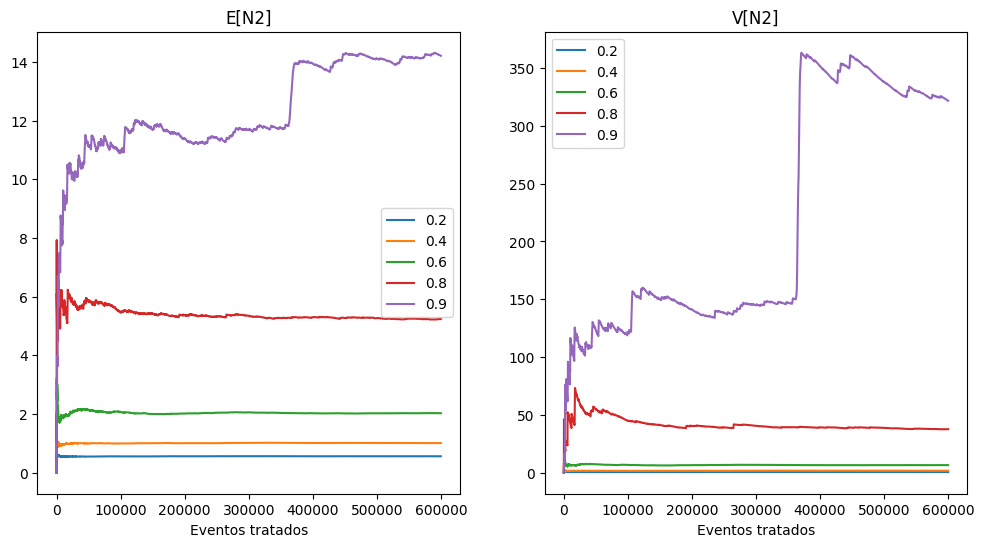

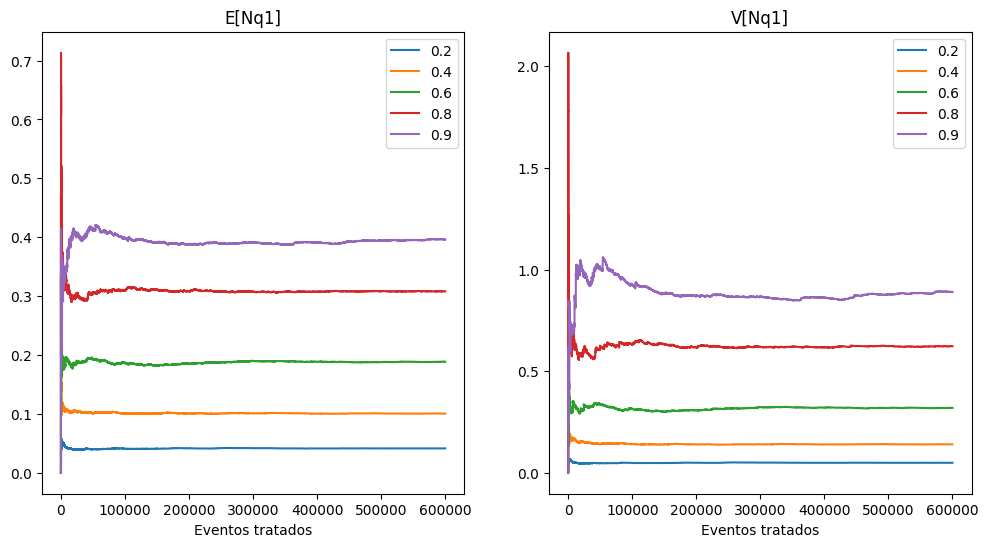

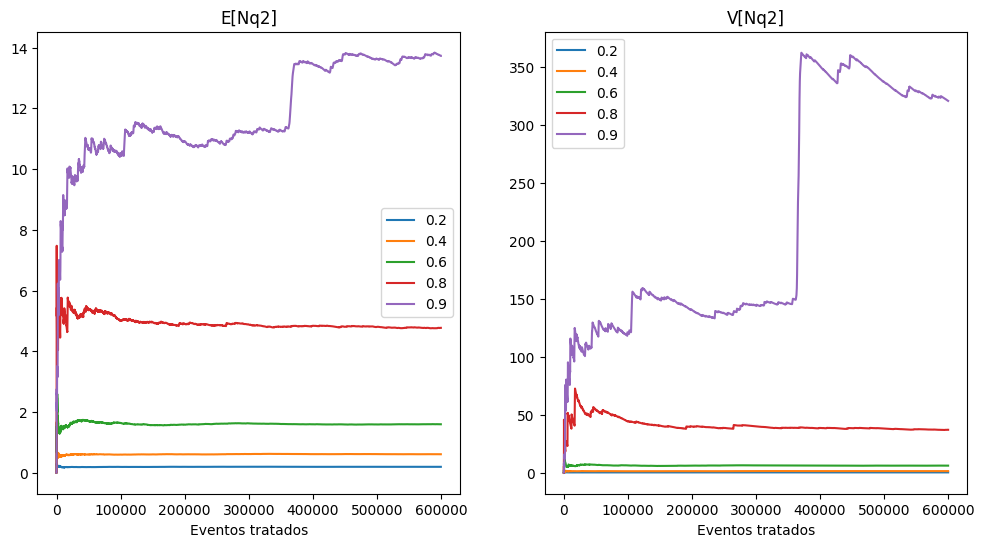

In [33]:
auxiliar_transiente(42, 200_000)

Usando seed 91

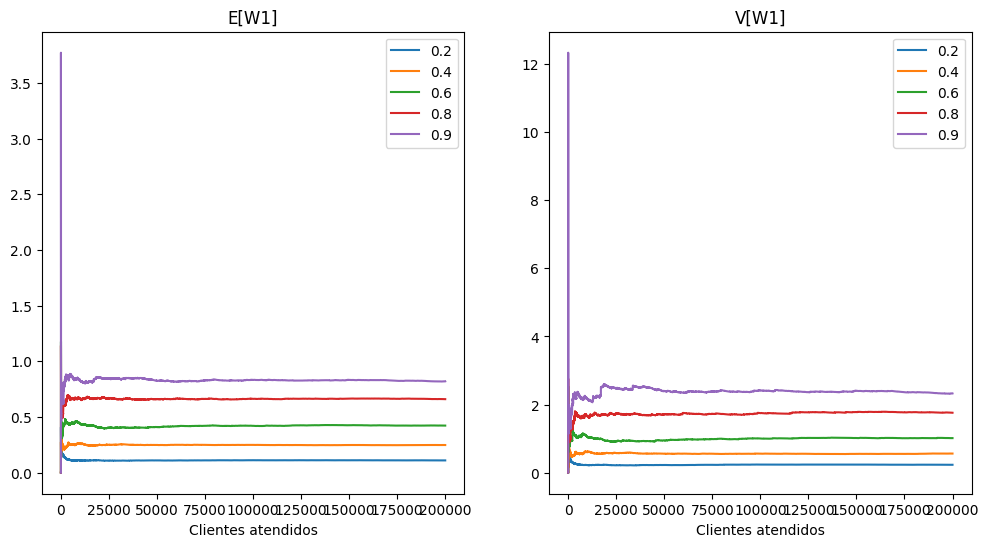

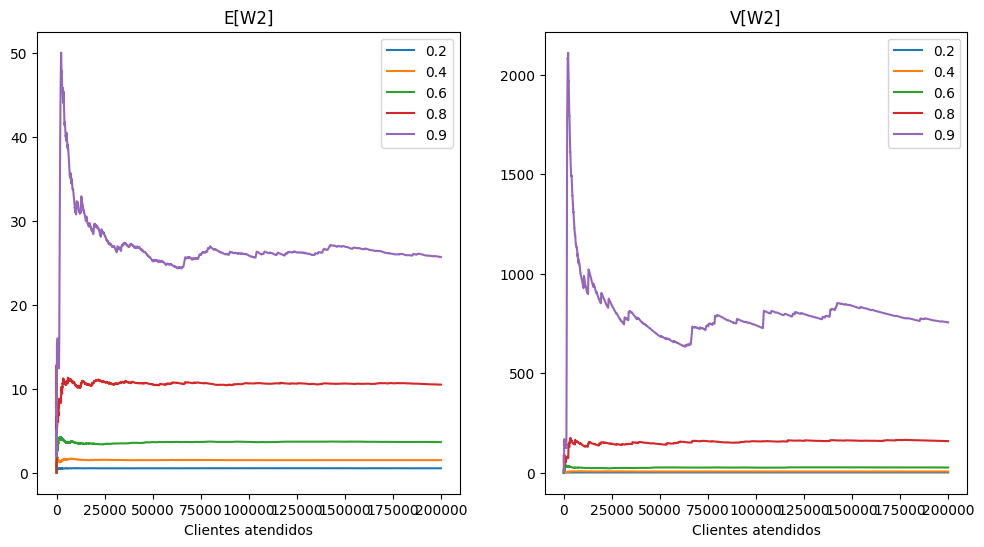

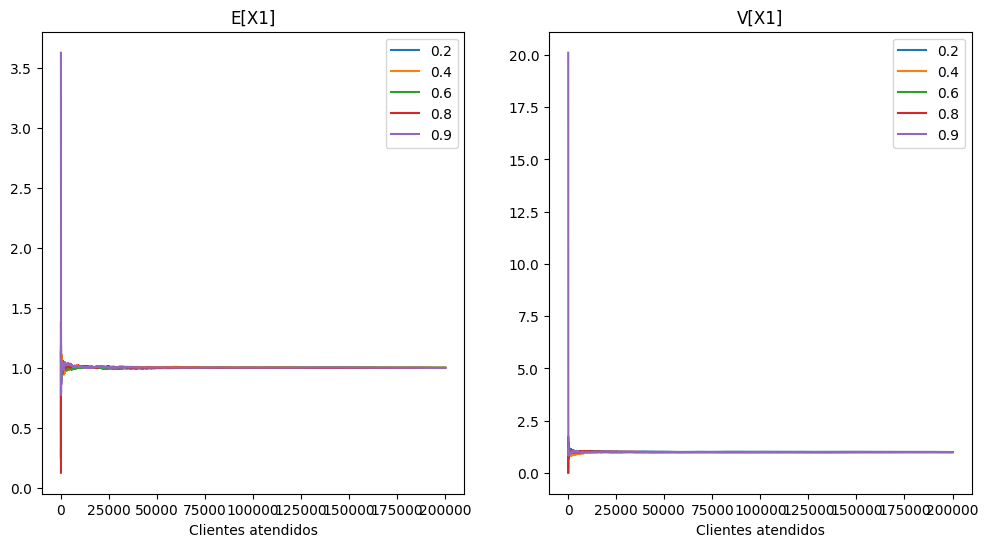

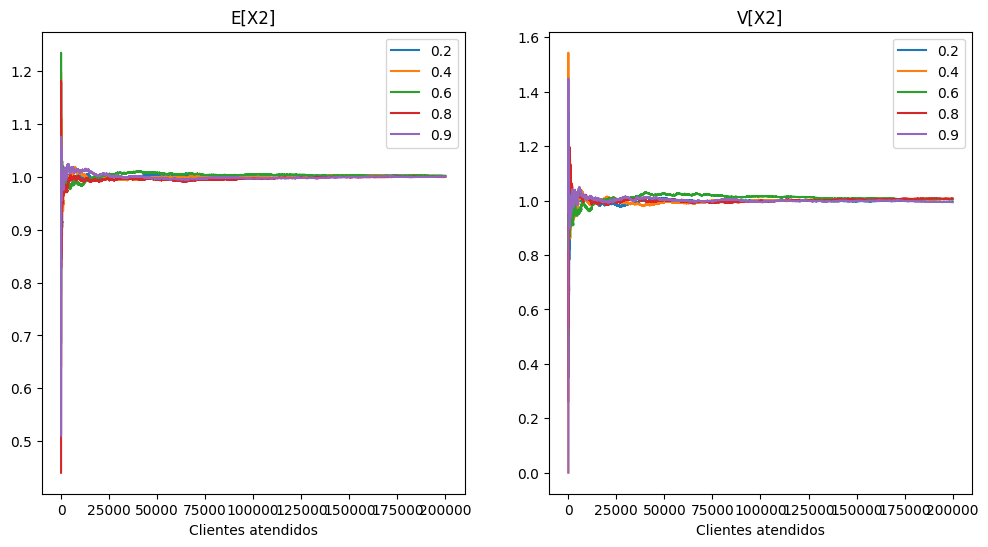

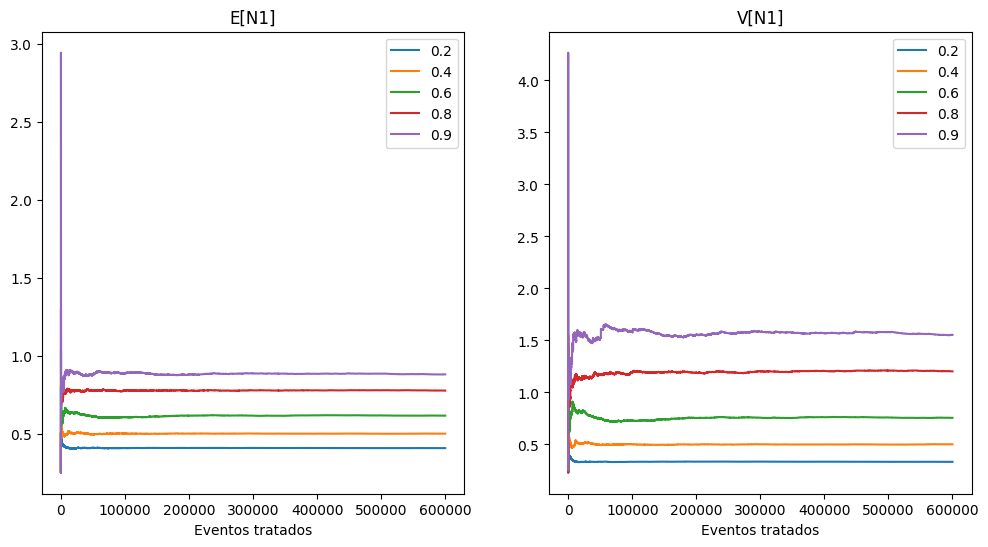

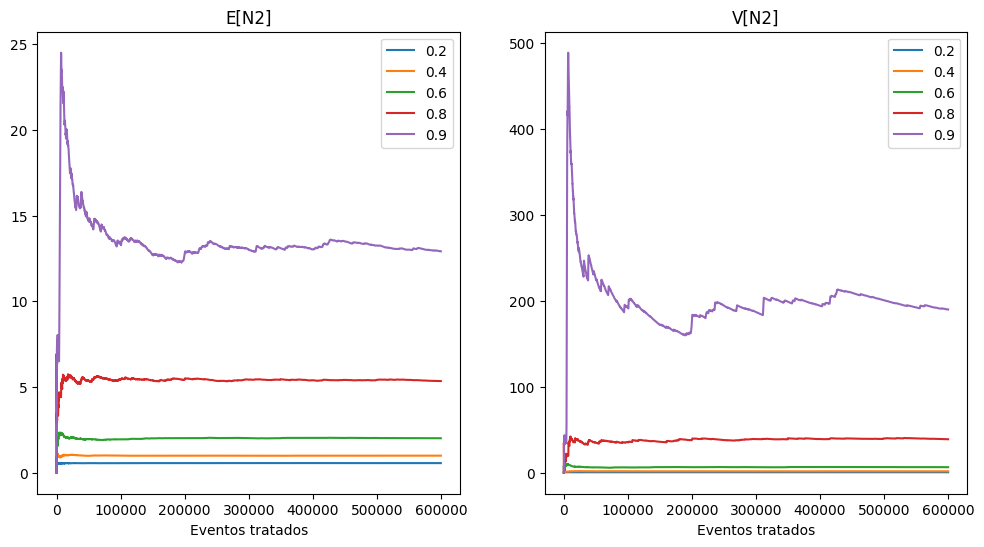

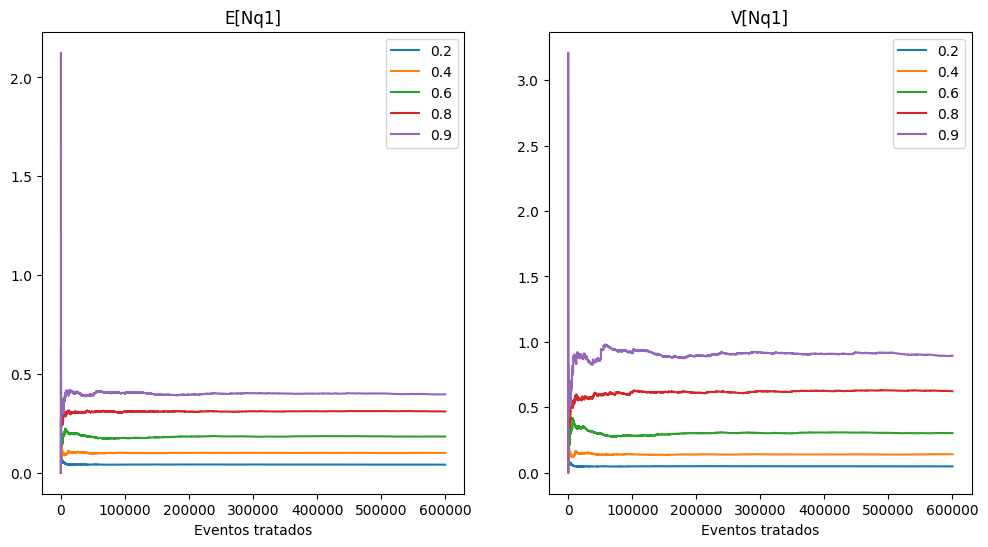

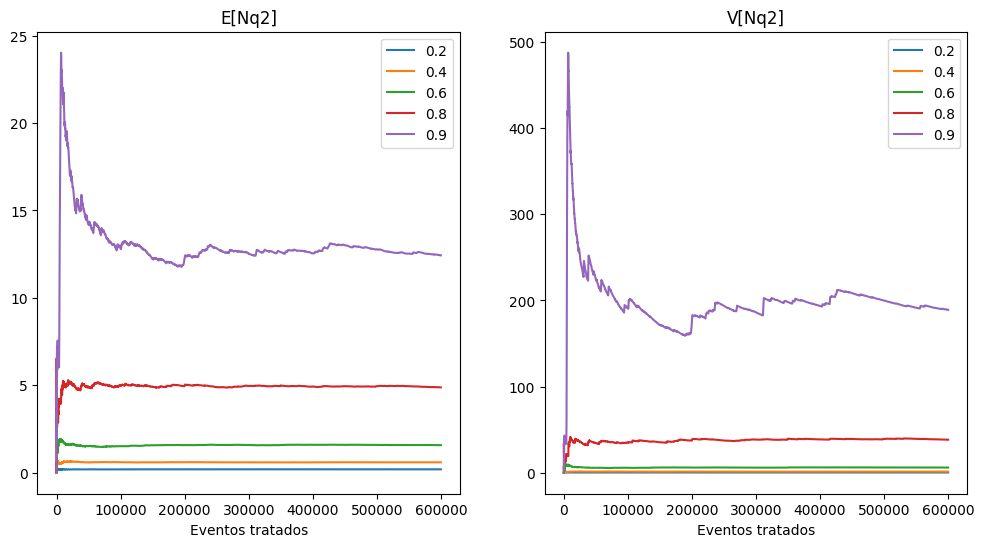

In [34]:
auxiliar_transiente(91, 200_000)

Feito isso, escolhemos usar os primeiros 200000 eventos como fase transiente.

### Coleta de resultados

Sabendo onde termina a fase transiente, vamos juntar tudo e adicionar a lógica de batch, onde cada simulação inicia onde a anterior termina. Para o tamanho de cada rodada, usaremos o número de partidas do sistema.

In [31]:
#lamb = lambda
#mu = mu
#n_rodadas = número de rodadas
#partidas_rodadas = número de partidas por rodada
def simulador(lamb, mu, n_rodadas, partidas_rodadas, debug=False):
    fila1 = []
    fila2 = []

    tempo = 0
    tempo_anterior = 0

    eventos = [ gera_chegadas(0, partial(gera_exponencial, lamb), 0) ] # começa populando com uma chegada
    
    estimadores = {
        "W1": Estimador(), "W2": Estimador(),
        "X1": Estimador(), "X2": Estimador(),
        "N1": Estimador(), "N2": Estimador(),
        "Nq1": Estimador(), "Nq2": Estimador()
    }
    rodada_atual = 0
    rodadas = [estimadores]
    partidas = 0

    i = 0
    while rodada_atual < n_rodadas+1: #loop de eventos, tratar k clientes
        if tempo > 100000 and partidas >= partidas_rodadas:
            partidas = 0
            rodada_atual += 1
            estimadores = {
                "W1": Estimador(), "W2": Estimador(),
                "X1": Estimador(), "X2": Estimador(),
                "N1": Estimador(), "N2": Estimador(),
                "Nq1": Estimador(), "Nq2": Estimador()
            }
            rodadas.append(estimadores)
        
        atual = eventos.pop(0)
        tempo_anterior = tempo
        tempo = atual.instante_t

        N1 = len(fila1)
        Nq1 = 0 if N1 == 0 else N1 - 1

        N2 = len(fila2)
        Nq2 = N2 if N1 > 0 or N2 == 0 else N2-1

        rodadas[rodada_atual]["N1"].adiciona_amostra(N1, peso=tempo-tempo_anterior)
        rodadas[rodada_atual]["Nq1"].adiciona_amostra(Nq1, peso=tempo-tempo_anterior)

        rodadas[rodada_atual]["N2"].adiciona_amostra(N2, peso=tempo-tempo_anterior)
        rodadas[rodada_atual]["Nq2"].adiciona_amostra(Nq2, peso=tempo-tempo_anterior)

        if atual.tipo_evento == CHEGADA: #evento de chegada
            fila1.append( cria_cliente(atual, rodada_atual) ) #adiciona o cliente chegado na fila
            eventos.append(gera_chegadas(tempo, partial(gera_exponencial, lamb), i) ) #cria o próximo evento de chegada
            #print("Chegada", fila1[-1])

            checa_termino = any([e.tipo_evento == FIM_DO_SERVICO_1 for e in eventos])
            if not checa_termino: #essa foi a primeira chegada (não tem pessoas na fila 1)
                prox_fim_1 = gera_fim_servico(tempo, partial(gera_exponencial, mu), atual.id_cliente, FIM_DO_SERVICO_1) 
                eventos.append( prox_fim_1 ) #adiciona o próximo evento de término 1

                if len(fila2) != 0: # fila 2 tem alguém sendo executado
                    prox_fim_2 = [e for e in eventos if e.tipo_evento == FIM_DO_SERVICO_2][0] #próximo término da fila 2
                    prox_fim_2.instante_t += prox_fim_1.tempo_execucao #adia o fim do próximo da fila 2 para após o fim do atual da fila 1
            i+= 1

        elif atual.tipo_evento == FIM_DO_SERVICO_1:
            cliente = fila1.pop(0) #remove o primeiro da fila 1
            fila2.append( cliente ) #coloca cliente na fila 2

            #atualiza tempos do cliente
            cliente.tempo_execucao_1= atual.tempo_execucao
            cliente.tempo_espera_1 = tempo - cliente.tempo_chegada - atual.tempo_execucao

            checa_termino = any([e.tipo_evento == FIM_DO_SERVICO_2 for e in eventos])
            if not checa_termino: #essa foi o primeiro termino (não tem pessoas na fila 2)
                eventos.append( gera_fim_servico(tempo, partial(gera_exponencial, mu), cliente.id, FIM_DO_SERVICO_2) ) #adiciona o próximo evento de término 1

            if len(fila1) == 0: #se a fila 1 estiver vazia
                pass
            else: #se a fila 1 não estiver vazia
                prox_fim_1 = gera_fim_servico(tempo, partial(gera_exponencial, mu), fila1[0].id, FIM_DO_SERVICO_1)  #cria evento de término para o próximo da fila 1
                eventos.append( prox_fim_1 ) 

                prox_fim_2 = [e for e in eventos if e.tipo_evento == FIM_DO_SERVICO_2][0] #próximo término da fila 2
                prox_fim_2.instante_t += prox_fim_1.tempo_execucao #adia o fim do próximo da fila 2 para após o fim do atual da fila 1

            #print("Saída 1", cliente)

        elif atual.tipo_evento == FIM_DO_SERVICO_2:
            cliente = fila2.pop(0)

            #atualiza tempos do cliente
            cliente.tempo_execucao_2= atual.tempo_execucao
            cliente.tempo_espera_2 = tempo - cliente.tempo_chegada - cliente.tempo_execucao_1 - cliente.tempo_espera_1 - atual.tempo_execucao

            if len(fila2) != 0:
                prox_fim_2 = gera_fim_servico(tempo, partial(gera_exponencial, mu), fila2[0].id, FIM_DO_SERVICO_2)
                eventos.append( prox_fim_2 )

            rodadas[cliente.cor]["W1"].adiciona_amostra(cliente.tempo_espera_1)
            rodadas[cliente.cor]["X1"].adiciona_amostra(cliente.tempo_execucao_1)

            rodadas[cliente.cor]["W2"].adiciona_amostra(cliente.tempo_espera_2)
            rodadas[cliente.cor]["X2"].adiciona_amostra(cliente.tempo_execucao_2)
            partidas += 1

        eventos.sort(key = lambda e: e.instante_t)
    return rodadas

In [33]:
random.seed(13) #setando uma seed pra manter os testes iguais

n_rodadas = 10
partidas_por_rodada = 100_000

mu = MU
lamb = RHOS[2]/2
retorno = simulador(lamb, mu, n_rodadas, partidas_por_rodada)

In [38]:
for metrica in ["W1", "W2", "X1", "X2", "N1", "N2", "Nq1", "Nq2"]:
    for estimador in retorno[1:-1]:
        print(estimador[metrica].t_student()[2] > 0.05) #testando se a precisão está sempre menor que 5%
    print()

False
False
False
False
False
False
False
False
False
False

False
False
False
False
False
False
False
False
False
False

False
False
False
False
False
False
False
False
False
False

False
False
False
False
False
False
False
False
False
False

False
False
False
False
False
False
False
False
False
False

False
False
False
False
False
False
False
False
False
False

False
False
False
False
False
False
False
False
False
False

False
False
False
False
False
False
False
False
False
False



## Testes de correção

### Corretude do simulador

## Estimativa da fase transiente